In [1]:
import pandas as pd
from functions import load_data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from igraph import Graph, Layout
from igraph import plot as g_plot
import cairocffi
from tqdm import tqdm
from geopy.distance import distance
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
%matplotlib inline

## Research question 3:

Can we detect certain loosely connected sub-networks which corresponds to a circle of friends or a city?

Here we investigate the structure of the social graph through the use of a community detection algorithm. We restricted ourselves to US check-ins because our main interest was in the distribution of cities in the communities, so introducing country borders would make the analysis much more complicated.

In [2]:
B_homes = pd.read_pickle('data/B_homes.pickle')
B_homes.columns = [col[0] for col in B_homes.columns]
B_homes = B_homes[B_homes['country'] == 'US']

print(B_homes.shape[0])
B_homes.head(5)

30663


,longitude,latitude,country
user_id,,,
0,-105.009140,39.756108,US
1,-122.353819,37.581821,US
2,-105.041977,39.771737,US
3,-122.424280,37.765768,US
5,-122.421897,37.752990,US


In [3]:
G_homes = pd.read_pickle('data/G_homes.pickle')
G_homes.columns = [col[0] for col in G_homes.columns]
G_homes = G_homes[G_homes['country'] == 'US']

print(G_homes.shape[0])
G_homes.head(5)

50618


,longitude,latitude,country
user_id,,,
0,-97.756394,30.260821,US
2,-118.338449,34.067629,US
4,-122.436562,37.775379,US
5,-97.723548,30.283573,US
7,-97.752399,30.268355,US


We remove lone vertices since they will always just result in a cluster of size one, which is not very interesting.

In [4]:
def clean_data(name, homes):
    _, edges = load_data(name)

    x = edges['from_id']
    y = edges['to_id']

    friends = set(zip(x,y)).intersection(set(zip(y,x))) #remove non bidirectional edges
    friends = set(map(lambda x: (x[0], x[1]) if x[0] < x[1] else (x[1], x[0]), friends)) #remove duplicates
    edges = pd.DataFrame(friends)
    # remove users with no home
    in_homes = edges.apply(lambda x: True if x[0] in homes.index and x[1] in homes.index else False, axis=1) 
    edges = edges[in_homes]
    # remove homes with no friends
    homes = homes[np.logical_or(homes.index.isin(edges[0]), homes.index.isin(edges[1]))]
    return homes, edges


In [5]:
B_homes, B_edges = clean_data("Brightkite", B_homes)
G_homes, G_edges = clean_data("Gowalla", G_homes)
print("Brightkite edges", B_edges.shape[0])
print("Gowalla edges", G_edges.shape[0])

Brightkite edges 107124
Gowalla edges 216518


We use the igraph library to create the graph, since it has implementations for several community detection algorithms.

In [6]:
def make_graph(homes, edges):
    id_map = {}
    g = Graph()

    for i, row in tqdm(homes.iterrows(), total=homes.shape[0]):
        vertex = g.add_vertex(Name=i) # Name the vertices since we need the user_id later
        id_map[i] = vertex.index
    edges = edges.apply(lambda x: (id_map[x[0]], id_map[x[1]]), axis=1)
    g.add_edges(edges)

    g = g.as_undirected()

    return g

In [7]:
B_graph = make_graph(B_homes, B_edges)
G_graph = make_graph(G_homes, G_edges)

100%|██████████| 46198/46198 [00:02<00:00, 20724.64it/s]


We use the walktrap algorithm (https://arxiv.org/pdf/physics/0512106.pdf). It is quite efficient, usually runs in $O(n²log(n))$ time for n vertices.

In [8]:
B_community = B_graph.community_walktrap()
B_clust = B_community.as_clustering()

For both data sets, the top 10 clusters follow similar distributions

Text(0.5, 1.0, 'Brightkite top ten cluster sizes')

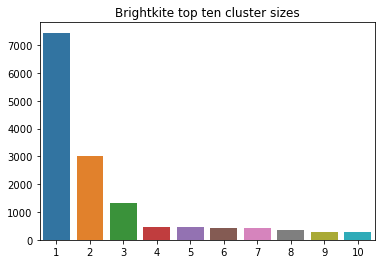

In [9]:
B_sizes = B_clust.sizes()
B_sorted_sizes = np.flip(np.sort(B_sizes))
B_arg_sizes = np.flip(np.argsort(B_sizes))
sns.barplot(np.arange(1,11), B_sorted_sizes[:10])
plt.title("Brightkite top ten cluster sizes")

In [10]:
"""fig = px.bar(y=B_sorted_sizes[:10], x=np.arange(1,11), orientation='v')
fig.update_layout(plot_bgcolor='seashell')
fig.update_traces(opacity=1)
fig.update_layout(
    title="Top ten cluster sizes",
    xaxis_title="Cluster",
    yaxis_title="Size"
    )

fig.show()

html = plot(fig, auto_open=False, output_type='div')
with open("plots/cluster_sizes.html", 'w') as file:
    file.write(html)"""

'fig = px.bar(y=B_sorted_sizes[:10], x=np.arange(1,11), orientation=\'v\')\nfig.update_layout(plot_bgcolor=\'seashell\')\nfig.update_traces(opacity=1)\nfig.update_layout(\n    title="Top ten cluster sizes",\n    xaxis_title="Cluster",\n    yaxis_title="Size"\n    )\n\nfig.show()\n\nhtml = plot(fig, auto_open=False, output_type=\'div\')\nwith open("plots/cluster_sizes.html", \'w\') as file:\n    file.write(html)'

In [11]:
G_community = G_graph.community_walktrap()
G_clust = G_community.as_clustering()

Text(0.5, 1.0, 'Gowalla top ten cluster sizes')

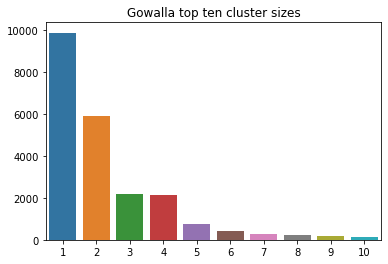

In [12]:
G_sizes = G_clust.sizes()
G_sorted_sizes = np.flip(np.sort(G_sizes))
G_arg_sizes = np.flip(np.argsort(G_sizes))
sns.barplot(np.arange(1,11), G_sorted_sizes[:10])
plt.title("Gowalla top ten cluster sizes")

In [13]:
# Gets the homes of the users in a cluster
def get_cluster_homes(cluster, homes):
    ids = []
    for v in cluster.vs:
        ids.append(v['Name'])
    return homes.loc[ids]

# Plots home locations on a map
def map_plot(data, name):
    px.set_mapbox_access_token(open("mapbox_token").read())
    fig = px.scatter_mapbox(data,
                            lat=data.latitude,
                            lon=data.longitude,
                            hover_name="country",
                            zoom=2)

    fig.update_traces(marker_color='peru', selector=dict(type='scattermapbox'))
    fig.update_traces(marker_opacity=0.9, selector=dict(type='scattermapbox'))
    fig.update_traces(marker_size=2, selector=dict(type='scattermapbox'))

    fig.show()


    html = plot(fig, auto_open=False, output_type='div')
    with open(f"./plots/{name}.html", 'w') as file:
        file.write(html)

In [14]:
tqdm.pandas()

# Gets the city counts in a dataframe with home locations
def get_city_counts(data):
    cities = pd.read_pickle('data/us_cities.pickle')
    data_merge = data.reset_index().merge(cities, left_on = 'country', right_on = 'iso2')
    data_merge['distance_to_city'] = data_merge.progress_apply(lambda row: distance((row['latitude'], row['longitude']),            (row['lat'],-row['lng']) ).km, axis = 1)
    data_lives_urban = data_merge.apply(lambda x: (x['distance_to_city'] < x['radius']), axis=1)
    return data_merge[data_lives_urban]['city'].value_counts()

In [15]:
n_samples = 5000

# Gets the homes and city counts from a cluster
def process_cluster(cluster, homes):
    homes = get_cluster_homes(cluster, homes)
    if homes.shape[0] > n_samples: # If cluster is too large, sample to get counts
        counts = get_city_counts(homes.sample(n_samples))
        counts /= n_samples
    else:
        counts = get_city_counts(homes)
        counts /= homes.shape[0]
    return homes, counts

Here we look at the top ten cities for the entire brightkite data set.

100%|██████████| 1585000/1585000 [05:05<00:00, 5186.66it/s]


Text(0.5, 1.0, 'Brightkite top 10 cities')

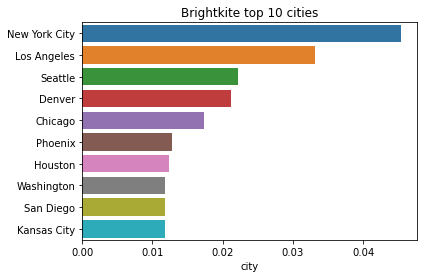

In [16]:
sample_homes = B_homes.sample(n_samples)
B_counts = get_city_counts(sample_homes)
B_counts /= n_samples
sns.barplot(B_counts[:10], B_counts.index[:10])
plt.title("Brightkite top 10 cities")

This is the largest cluster found in the brightkite data set. It contains about 25% of all users. As we can see it is quite spread out geographically, with no city clearly dominating. This might indicate that the users quite well connected across space. 

100%|██████████| 1585000/1585000 [05:07<00:00, 5148.99it/s]


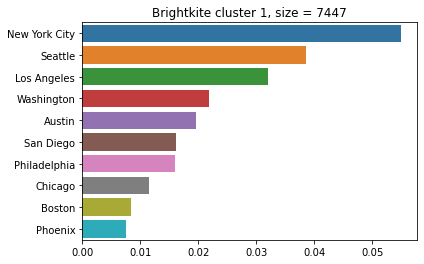

In [17]:
homes, counts = process_cluster(B_clust.subgraph(B_arg_sizes[0]), B_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Brightkite cluster 1, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"B{1}_us")

The second cluster found. Again quite spread out. The three largest cities in the cluster are all very far apart, one on the west coast, one in the midwest and one on the east coast.

100%|██████████| 953536/953536 [03:05<00:00, 5129.62it/s]


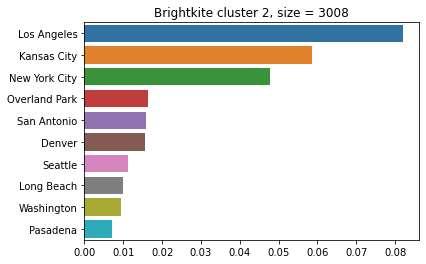

In [24]:
homes, counts = process_cluster(B_clust.subgraph(B_arg_sizes[1]), B_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Brightkite cluster 2, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"B{2}_us")

The third cluster is the first which is restricted geographically, it is dominated by two nearby cities, Denver and Boulder. It is perhaps a bit interesting that the first one of these restricted clusters was not dominated by New York or Los Angeles, which are the two largest cities in the overall data set.

100%|██████████| 420976/420976 [01:20<00:00, 5255.06it/s]


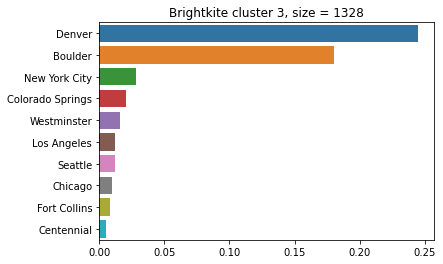

In [18]:
homes, counts = process_cluster(B_clust.subgraph(B_arg_sizes[2]), B_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Brightkite cluster 3, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"B{3}_us")

The fourth cluster is again restricted geographically, it is dominated by Texan cities, mainly Houston and Dallas.

100%|██████████| 149307/149307 [00:28<00:00, 5324.79it/s]


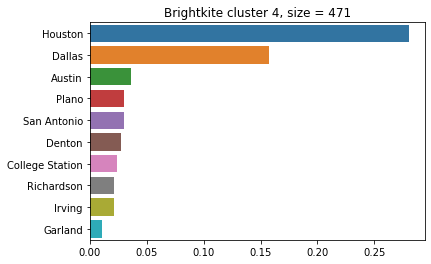

In [25]:
homes, counts = process_cluster(B_clust.subgraph(B_arg_sizes[3]), B_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Brightkite cluster 4, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"B{4}_us")

For the gowalla data set we see that the largest city is, by quite a large margin, Austin. This is a bit surprising since it is only the 11th largest city (as of today) in the US. It seems that this social network was particularily popular in Austin. This might be related to the fact that Austin is very underrepresented in the brightkite data set, with the Texan cluster being dominated by Houston and Dallas. Since the check-ins are from the same time period what we are seeing might be the two social networks competing for users, with users from each network being concentrated in different cities.

100%|██████████| 1585000/1585000 [05:07<00:00, 5162.25it/s]


Text(0.5, 1.0, 'Gowalla top 10 cities')

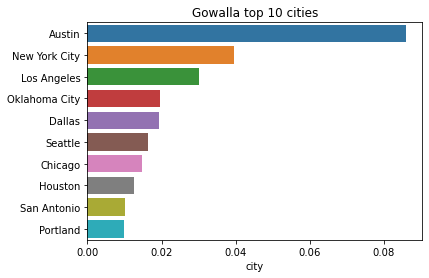

In [20]:
n_samples = 5000
sample_homes = G_homes.sample(n_samples)
G_counts = get_city_counts(sample_homes)
G_counts /= n_samples 
sns.barplot(G_counts[:10], G_counts.index[:10])
plt.title("Gowalla top 10 cities")

Just as with brightkite, the largest cluster is quite spread out.

100%|██████████| 1585000/1585000 [05:08<00:00, 5144.77it/s]


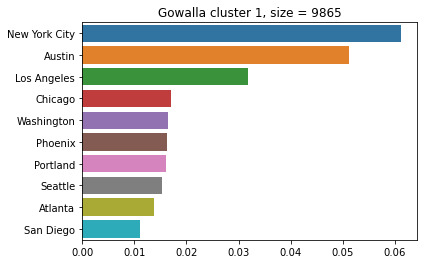

In [21]:
homes, counts = process_cluster(G_clust.subgraph(G_arg_sizes[0]), G_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Gowalla cluster {1}, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"G{1}_us")

The second cluster is also fairly spread out, but it is a bit more concentrated in Texas, with 3 of the top 4 cities being in Texas.

100%|██████████| 1585000/1585000 [05:12<00:00, 5069.69it/s]


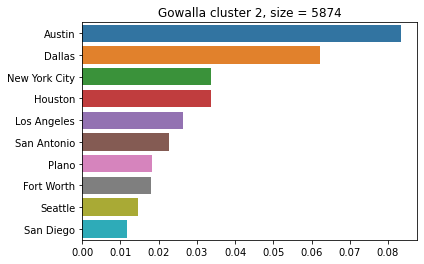

In [26]:
homes, counts = process_cluster(G_clust.subgraph(G_arg_sizes[1]), G_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Gowalla cluster {2}, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"G{2}_us")

The third cluster is dominated by Austin. Compared to the previous one, it is much more concentrated, with over 60% of users living in Austin.

100%|██████████| 692328/692328 [02:10<00:00, 5304.52it/s]


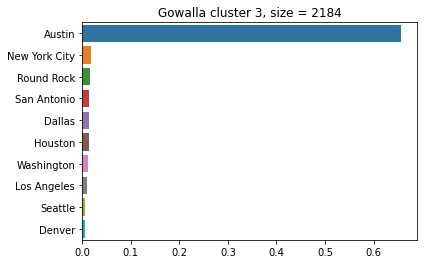

In [22]:
homes, counts = process_cluster(G_clust.subgraph(G_arg_sizes[2]), G_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Gowalla cluster {3}, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"G{3}_us")

The fourth cluster is similar to the second cluster in the brightkite data set. It is dominated by three large cities which are very far apart.

100%|██████████| 680599/680599 [02:14<00:00, 5062.91it/s]


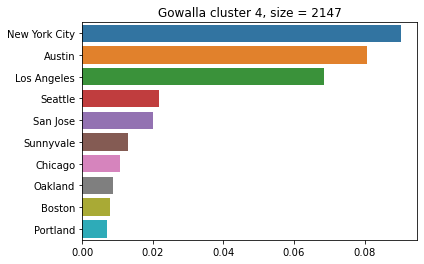

In [27]:
homes, counts = process_cluster(G_clust.subgraph(G_arg_sizes[3]), G_homes)
sns.barplot(counts[:10], counts.index[:10])
plt.title(f"Gowalla cluster {4}, size = {homes.shape[0]}")
plt.xlabel("")
map_plot(homes, f"G{4}_us")